In [2]:
# data source

# seller_scam
data_file_seller = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v2/experiment/exp3/seller_scam_login_sample_feature_v3_1657603289837.txt'
# total_Ato
data_file_ato = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v2/experiment/exp3/ato_login_sample_feature_v3_1657603282655.txt'



# define venture, entrance (all entrance)
venture = 'ID'


# define whether to display feature importance, shap or PR curve on test data
is_grid_search, is_feature_importance, is_shap, is_plot_pr = True, True, True, True
# define whether to skip some sections, False means do not run that part
is_save_model, is_plot_interactive_pr, is_plot_thrhld_bin = False, True, True

# model feature list
features_to_use = [
                  'id_new_ip2_3m',
                  'id_new_ip3_3m',
                  'no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'no_login_14d',
                  'id_ip_same_seller_14d',
                  'id_ip3ua_same_seller_14d',
                  'avg_price_per_order_usd_14d',
                  'std_price_per_order_usd_14d',
                  'avg_dscnt_rate_per_order_14d',
                  'std_dscnt_rate_per_order_14d',
                  'avg_shpfee_per_order_usd_14d',
                  'std_shpfee_per_order_usd_14d',
                  'id_susp_paymethod_14d',
                  'no_acct_umid_3m',
                  'max_cancel_rate_14d',
                  'max_avg_price_seller_usd_14d',
                  'max_avg_dscnt_rate_seller_14d',
                  'max_avg_shpfee_seller_usd_14d'
                     ]

# For EDA
features_type = [True,
                 True,
                 False,
                 False,
                 False,
                 True,
                 True,
                 False,
                 False,
                 False,
                 False,
                 False,
                 False,
                 True,
                 False,
                 False,
                 False,
                 False,
                 False
                ]

byr_idx_cols = ['label', 'buyer_id']

# feature list that needs to impute
features_to_impute = ['id_new_ip2_3m',
                  'id_new_ip3_3m',
                  'no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'no_login_14d',
                  'id_ip_same_seller_14d',
                  'id_ip3ua_same_seller_14d',
                  'avg_price_per_order_usd_14d',
                  'std_price_per_order_usd_14d',
                  'avg_dscnt_rate_per_order_14d',
                  'std_dscnt_rate_per_order_14d',
                  'avg_shpfee_per_order_usd_14d',
                  'std_shpfee_per_order_usd_14d',
                  'id_susp_paymethod_14d',
                  'no_acct_umid_3m',
                  'max_cancel_rate_14d',
                  'max_avg_price_seller_usd_14d',
                  'max_avg_dscnt_rate_seller_14d',
                  'max_avg_shpfee_seller_usd_14d'
                     ]

model_list = ['rf', 'xgb']


# params of model
rf_default_param = {'bootstrap': True, 'oob_score': True, 'max_depth':10, 'n_estimators': 120, 'criterion':'gini',
             'n_jobs': -1, 'random_state': 0
               , 'class_weight': 'balanced'
            }

rf_param_grid = {
            'max_depth': [2, 8, 16],
            'n_estimators': [32, 64, 128],
            'min_samples_leaf' : [5, 20, 30],
            'bootstrap': [True], 
            'oob_score': [True], 
            'criterion':['gini'],
            'random_state': [0], 
            'class_weight': ['balanced']
            }    

xgb_default_param = {'verbosity':0, 'n_jobs': -1, 'random_state':0}
xgb_param_grid = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 5, 10],
            'verbosity':[0],
            'use_label_encoder':[False],
            'random_state': [0]
            }              

model_params = {'rf': [rf_default_param, rf_param_grid],
                'xgb': [xgb_default_param, xgb_param_grid]
               }

# seed for generating the training / testing set
random_state = 42
test_size = 0.2
cv = 5
threshold_setting = 0.5

# Import Packages

In [3]:
%pip install xgboost
%pip install shap
%pip install plotly
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px

import json
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, precision_recall_curve, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
import shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Functions

In [4]:
# define function to reduce data size
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df




# define function to plot PR curve
def plot_pr(y, pred):
    # based on different thresholds
    precision, recall, thresholds = precision_recall_curve(y, pred)

    f1_scores = []
    for i in range(len(thresholds)):
        f1_scores.append(2*recall[i]*precision[i]/(recall[i]+precision[i]))
    
    # select the best model according to the f1-score
    ix = np.argmax(f1_scores)
#     print('Best threshold: ', thresholds[ix])
#     print('Best F1-Score: ', np.max(f1_scores))

    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.scatter(recall[ix], precision[ix], marker='o', color='red', label='Best')

    # add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()

    return thresholds[ix], precision, recall, thresholds, f1_scores

# EDA
# display the distribution of features
## col2 represents the label
### col1 reprensts the features
def display_kdeplot(df, col1, col2, is_cat):
    df[col1] = df[col1].astype(float)
    plt.figure(figsize = (15, 6))
    if is_cat:
        sns.countplot(data = df, x = col1, hue = col2)
    else:
        ax = plt.axes()
        sns.kdeplot(data = df[df[col2] == 0], x = col1, color = 'darkorange', label = 'Non-ATO')
        ax_bis = ax.twinx()
        sns.kdeplot(data = df[df[col2] == 1], x = col1, label = 'ATO')
        plt.title(col1)
        ax.legend(loc = 'upper left')
        ax_bis.legend(loc = 'upper right')
        # ax.set_xscale('log')
    plt.show()
    
    print(df.groupby(col2)[col1].describe())
    print(col1)
    
##----------------------------------------------------------------------------------------------------
# given the whole data, feature list and testing set parameters (size and random seed)
## return the training set and testing set
def train_test_generation(df, features_to_use, byr_idx_cols, test_size, random_state):
    feature_list = byr_idx_cols + features_to_use
    # only select the features we need
    df = df[feature_list].astype(float)
    
    y = df['label']
    
    df_train, df_test, y_train, y_test = train_test_split(df, y, test_size = test_size, random_state = random_state)
    
    X_train, X_test = df_train[features_to_use], df_test[features_to_use]
    
    return X_train, y_train, X_test, y_test, df_test

# given ground-truth label and predicted label
## return performance metric
def display_model_metrics(y, y_pred):
    print('     F1 score:', f1_score(y, y_pred))
    print('     AUC:', roc_auc_score(y, y_pred))
    print('     Accuracy:', accuracy_score(y, y_pred))
    print('     Precision:', precision_score(y, y_pred))
    print('     Recall:', recall_score(y, y_pred))
    print("\tConfusion matrix：\n", confusion_matrix(y, y_pred))
    
    
# given model (non-parametrized classifier), grid parameters, cross-valdiation folds, dataset
## return best parameters
def model_grid_search(is_grid_search, clf_gs, param_grid, default_param, cv, x, y):
    if is_grid_search:
        grid_search = GridSearchCV(estimator = clf_gs,
                                  param_grid = param_grid,
                                  scoring = 'roc_auc',
                                  cv = cv,
                                  verbose = 1,
                                  n_jobs = 1
                                  )
        grid_search.fit(x, y)
        best_param = grid_search.best_params_
    else:
        best_param = default_param
        
    print('====> grid search parameters: \n{')
    [print(key,':',value) for key, value in param_grid.items()]
    print('}\n')
        
    print('====> best estimator: \n{')
    [print(key,':',value) for key, value in best_param.items()]
    print('}\n')
    
    return best_param


# given parametrized model, splited data (training + testing), threshold (for confusion matrix) and
# feature list (for feature importance),
## return feature importance, training and testing confusion matrix, shapley value, PR-curve and 
## probability prediction

def model_train(mod, X_train, y_train, X_test, y_test, 
                threshold, features_to_use,
                is_feature_importance, is_shap, is_plot_pr):
    
    mod.fit(X_train, y_train)
    
    # model prediction on training set
    y_train_preds = mod.predict(X_train)
    y_train_preds_prob = mod.predict_proba(X_train)
    train_preds = [1 if y_train_preds_prob[i][1] > threshold else 0 for i in range(len(y_train_preds_prob))]
    print("=============================================================")
    print(f'Train:')
    print('Label distribution:\n{}\n'.format(y_train.value_counts()))
    display_model_metrics(y_train, train_preds)
    
    # model prediction on testing set
    y_test_preds = mod.predict(X_test)
    y_test_preds_prob = mod.predict_proba(X_test)
    test_preds = [1 if y_test_preds_prob[i][1] > threshold else 0 for i in range(len(y_test_preds_prob))]
    print("\n=============================================================")
    print('Testing:')
    print('Label distribution:\n{}\n'.format(y_test.value_counts()))
    display_model_metrics(y_test, test_preds)
    
    output_list = [mod]

    
    # feature importance
    if is_feature_importance is True:
        print("=============================================================")
        print(pd.DataFrame({'feature': list(features_to_use),
               'importance': mod.feature_importances_}).\
                sort_values('importance', ascending = False))
    # shapley value
    if is_shap is True:
        print("=============================================================")
        print('SHAP explanation: \n')
        explainer = shap.TreeExplainer(mod)
        shap_values = explainer.shap_values(X_test)
        try: 
            shap.summary_plot(shap_values[1], X_test, max_display=30)
        except:
            shap.summary_plot(shap_values, X_test, max_display=30)
    # precision-recall curve
    if is_plot_pr is True:
        print("=============================================================")
        thres, precision, recall, thresholds, f1_scores = plot_pr(y_test, y_test_preds_prob[:, 1])
        output_list.append([thres, precision, recall, thresholds, f1_scores])
    
    output_list.append(y_test_preds_prob[:,1])
    
    return output_list


# Main function to cover all model training details
## Given dataset and random seed (random state), first generating training and testing set
### then use cv to achieve best parameters
#### finally use best parmaters to achieve model performance
def run_model(df, features_to_use, byr_idx_cols, cv,
              model_name, model_param, threshold, 
              is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state):
    
    X_train, y_train, X_test, y_test, df_test = train_test_generation(df, features_to_use, byr_idx_cols,
                                                                test_size, random_state)
    
    
    # model training
    x, y = X_train, y_train

    # RF
    if model_name == 'rf':
        print('=============================================================')
        print('                    Random forest model                      ')
        print('=============================================================')
        
        # grid search
        clf_gs = RandomForestClassifier()
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], cv, x, y)
        clf = RandomForestClassifier(**best_param)
        
    # xgboost
    elif model_name == 'xgb':
        print('=============================================================')
        print('                      Xgboost model                          ')
        print('=============================================================')
        # grid search
        clf_gs = xgb.XGBClassifier()   
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], cv, x, y)
        clf = xgb.XGBClassifier(**best_param)   
        
                
    output_list = model_train(clf, X_train, y_train, X_test, y_test, threshold,
                                  features_to_use, is_feature_importance, is_shap, is_plot_pr,
                                 )

    return output_list

# Main Code

## 1. Load Data (seller-scam version) and calculate black samples percentage

In [5]:
df = pd.read_csv(data_file_seller, delimiter = ',', dtype = str)
df['label'] = df['label'].astype(float)

# Calculate percent of black samples
bl_cnt = (df.label==1).astype(float).sum()
total = (df.label!=-1).astype(float).sum()
percent = round((bl_cnt / total)*100, 2)

print(bl_cnt, 'black samples out of a total of', total, 'samples.')
print('Black sample percent: ' +  str(percent) + '%')

524.0 black samples out of a total of 6524.0 samples.
Black sample percent: 8.03%


## 2. impute null values with -1

In [6]:
# impute null values
# replace null value with -1

df = df.replace('\\N', -1)
df[features_to_impute] = df[features_to_impute].astype(float)

## 3. EDA

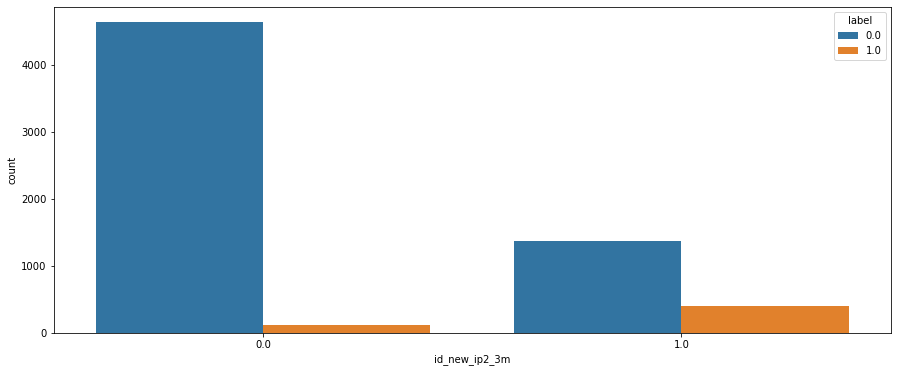

        count      mean       std  min  25%  50%  75%  max
label                                                     
0.0    6000.0  0.228000  0.419578  0.0  0.0  0.0  0.0  1.0
1.0     524.0  0.767176  0.423035  0.0  1.0  1.0  1.0  1.0
id_new_ip2_3m
------------------------------------------------------------------------


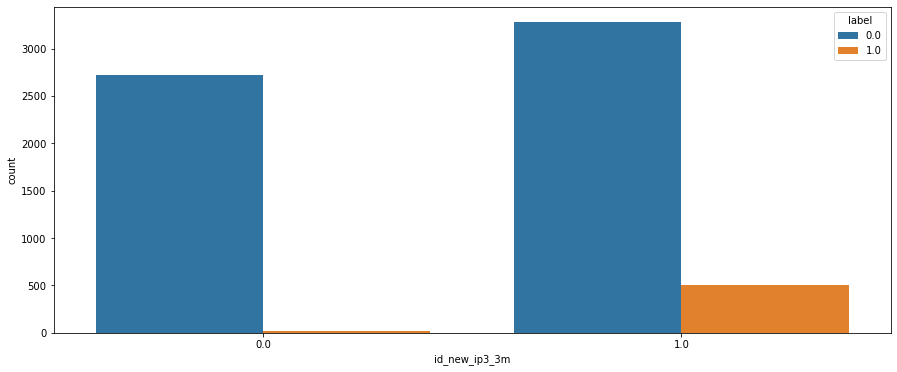

        count      mean       std  min  25%  50%  75%  max
label                                                     
0.0    6000.0  0.546167  0.497906  0.0  0.0  1.0  1.0  1.0
1.0     524.0  0.954198  0.209254  0.0  1.0  1.0  1.0  1.0
id_new_ip3_3m
------------------------------------------------------------------------


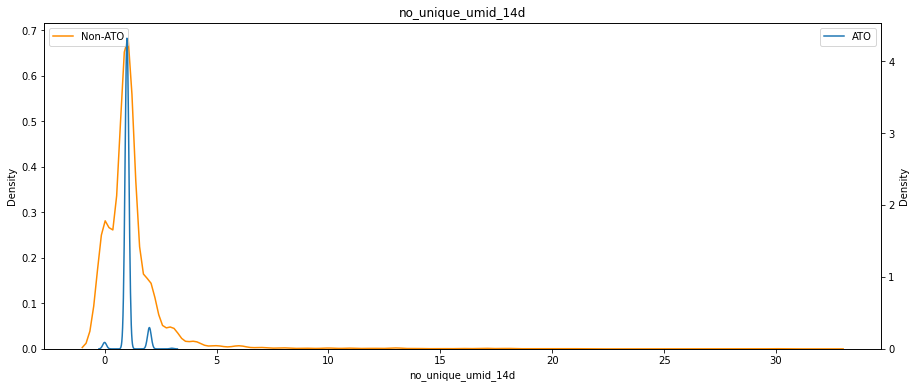

        count      mean       std  min  25%  50%  75%   max
label                                                      
0.0    6000.0  1.256667  1.897030  0.0  1.0  1.0  1.0  32.0
1.0     524.0  1.047710  0.295949  0.0  1.0  1.0  1.0   3.0
no_unique_umid_14d
------------------------------------------------------------------------


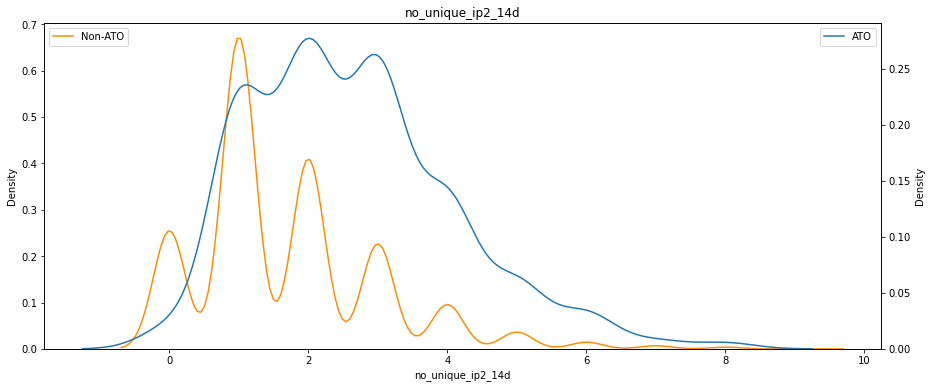

        count      mean       std  min  25%  50%  75%  max
label                                                     
0.0    6000.0  1.685167  1.319976  0.0  1.0  1.0  2.0  9.0
1.0     524.0  2.633588  1.463154  0.0  2.0  2.0  3.0  8.0
no_unique_ip2_14d
------------------------------------------------------------------------


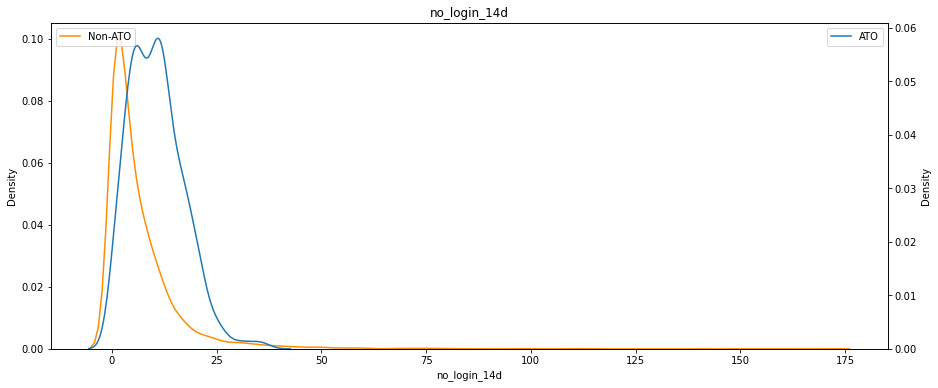

        count       mean       std  min  25%   50%   75%    max
label                                                          
0.0    6000.0   6.686333  9.675926  0.0  1.0   4.0   9.0  171.0
1.0     524.0  10.616412  6.513099  0.0  6.0  10.0  14.0   37.0
no_login_14d
------------------------------------------------------------------------


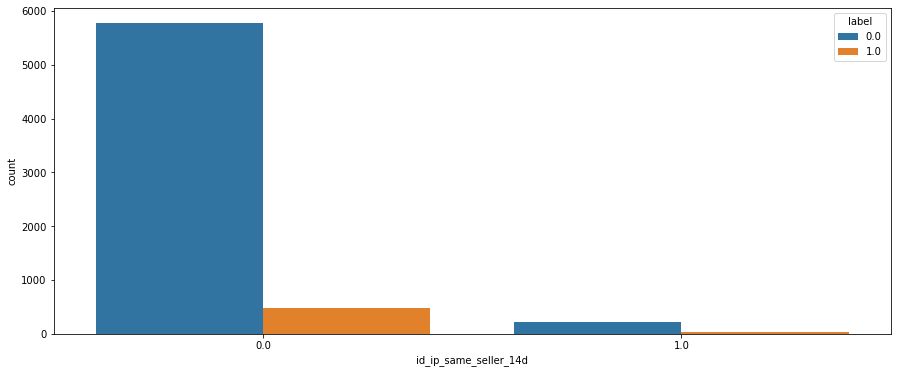

        count      mean       std  min  25%  50%  75%  max
label                                                     
0.0    6000.0  0.038333  0.192016  0.0  0.0  0.0  0.0  1.0
1.0     524.0  0.076336  0.265789  0.0  0.0  0.0  0.0  1.0
id_ip_same_seller_14d
------------------------------------------------------------------------


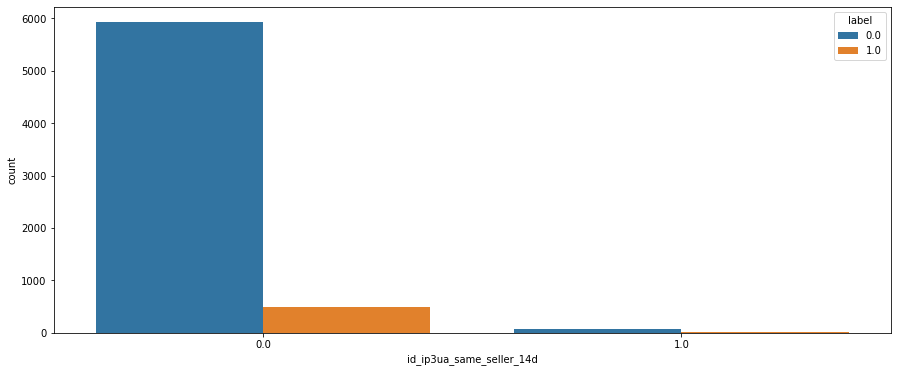

        count      mean       std  min  25%  50%  75%  max
label                                                     
0.0    6000.0  0.013000  0.113283  0.0  0.0  0.0  0.0  1.0
1.0     524.0  0.049618  0.217363  0.0  0.0  0.0  0.0  1.0
id_ip3ua_same_seller_14d
------------------------------------------------------------------------


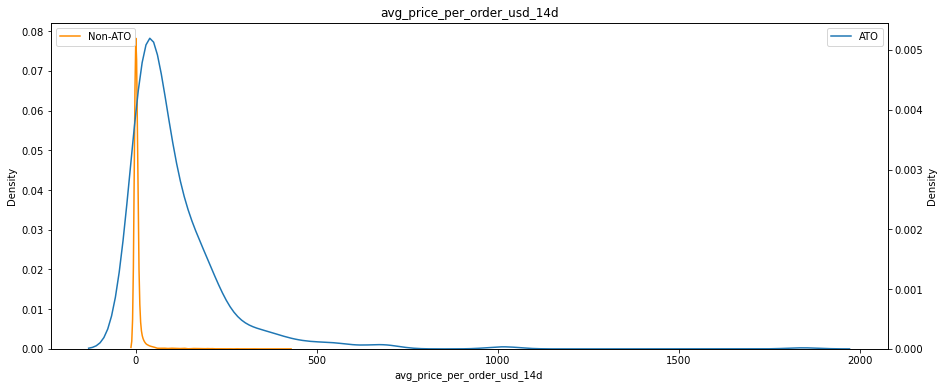

        count        mean         std  min        25%        50%         75%  \
label                                                                          
0.0    6000.0    5.879803   21.889053 -1.0  -0.250000   1.509971    4.078596   
1.0     524.0  110.252666  149.811158 -1.0  24.316157  62.650275  149.553594   

               max  
label               
0.0     418.108320  
1.0    1843.119608  
avg_price_per_order_usd_14d
------------------------------------------------------------------------


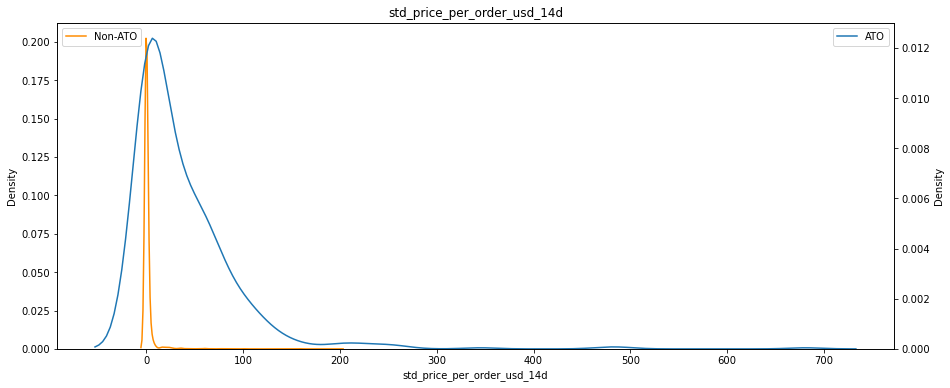

        count       mean        std  min   25%        50%        75%  \
label                                                                  
0.0    6000.0   1.374191   8.919396 -1.0 -0.25   0.000000   0.561674   
1.0     524.0  38.364669  60.830967 -1.0  0.00  19.245758  57.903317   

              max  
label              
0.0    198.530074  
1.0    680.887498  
std_price_per_order_usd_14d
------------------------------------------------------------------------


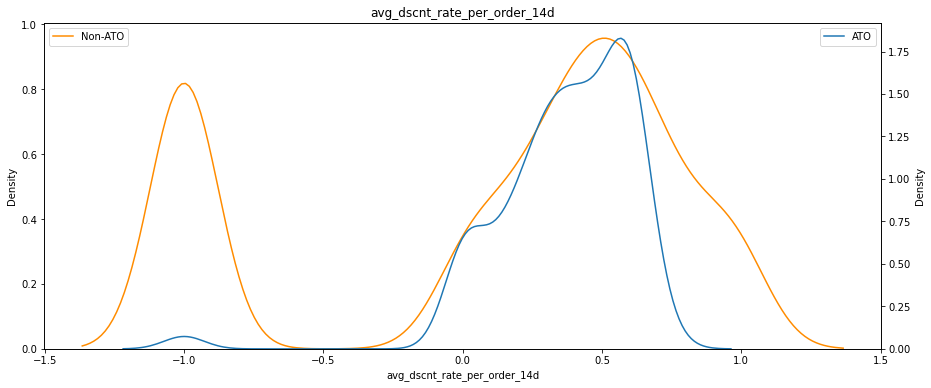

        count      mean       std  min       25%       50%       75%      max
label                                                                        
0.0    6000.0  0.124601  0.694323 -1.0 -0.875000  0.380023  0.620858  1.00000
1.0     524.0  0.365968  0.255247 -1.0  0.243002  0.403050  0.569867  0.74404
avg_dscnt_rate_per_order_14d
------------------------------------------------------------------------


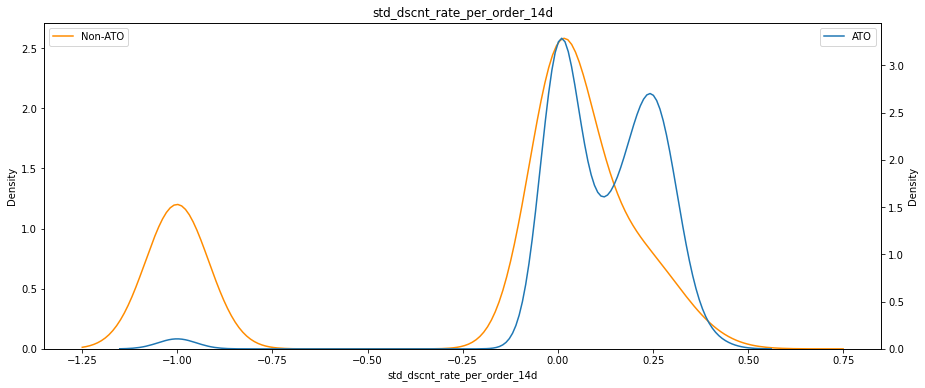

        count      mean       std  min   25%       50%       75%       max
label                                                                     
0.0    6000.0 -0.196040  0.473049 -1.0 -0.25  0.000000  0.075275  0.500000
1.0     524.0  0.116661  0.175762 -1.0  0.00  0.125649  0.241629  0.409565
std_dscnt_rate_per_order_14d
------------------------------------------------------------------------


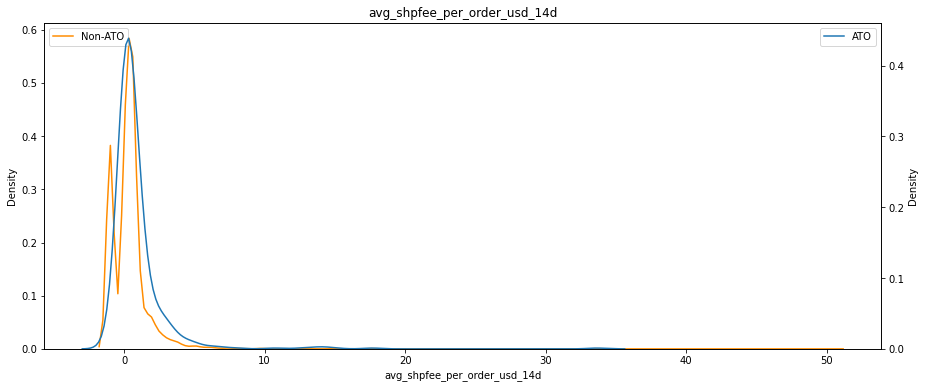

        count      mean       std  min   25%       50%       75%        max
label                                                                      
0.0    6000.0  0.338855  1.482705 -1.0 -0.25  0.365534  0.625809  50.377638
1.0     524.0  0.911509  2.314062 -1.0  0.00  0.333224  0.871622  33.628482
avg_shpfee_per_order_usd_14d
------------------------------------------------------------------------


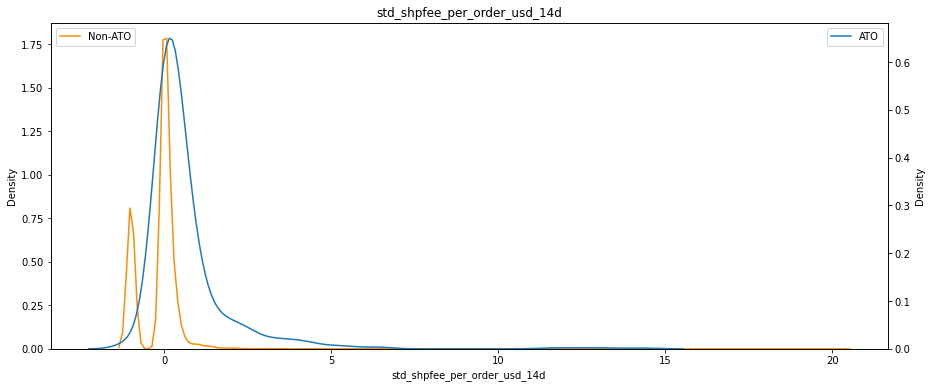

        count      mean       std  min   25%       50%       75%        max
label                                                                      
0.0    6000.0 -0.150377  0.681690 -1.0 -0.25  0.000000  0.017134  20.159653
1.0     524.0  0.674392  1.476482 -1.0  0.00  0.240452  0.705302  14.277232
std_shpfee_per_order_usd_14d
------------------------------------------------------------------------


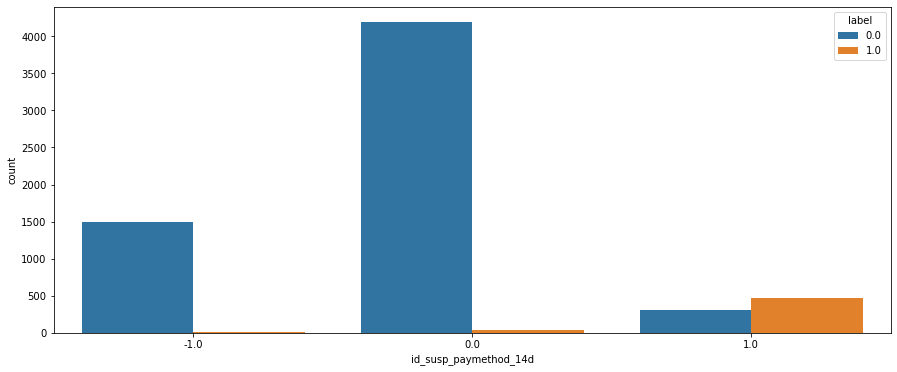

        count      mean       std  min   25%  50%  75%  max
label                                                      
0.0    6000.0 -0.198000  0.512679 -1.0 -0.25  0.0  0.0  1.0
1.0     524.0  0.887405  0.356199 -1.0  1.00  1.0  1.0  1.0
id_susp_paymethod_14d
------------------------------------------------------------------------


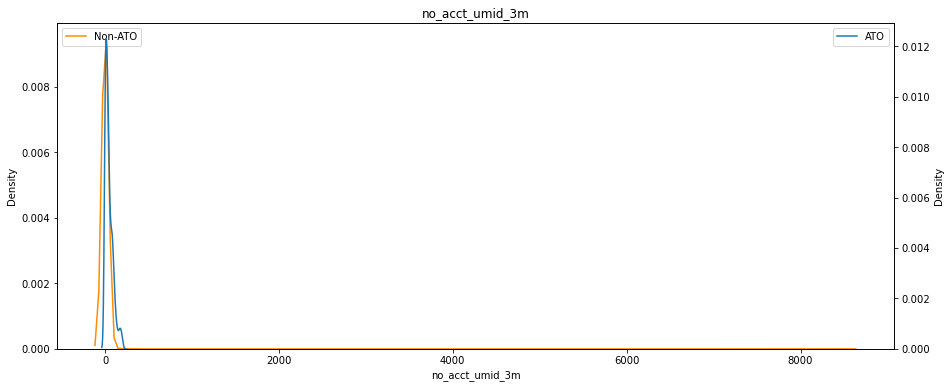

        count       mean         std  min   25%   50%   75%     max
label                                                              
0.0    6000.0   7.676667  220.997364  0.0  0.00   0.0   0.0  8521.0
1.0     524.0  44.471374   44.030030  0.0  9.75  31.5  69.0   199.0
no_acct_umid_3m
------------------------------------------------------------------------


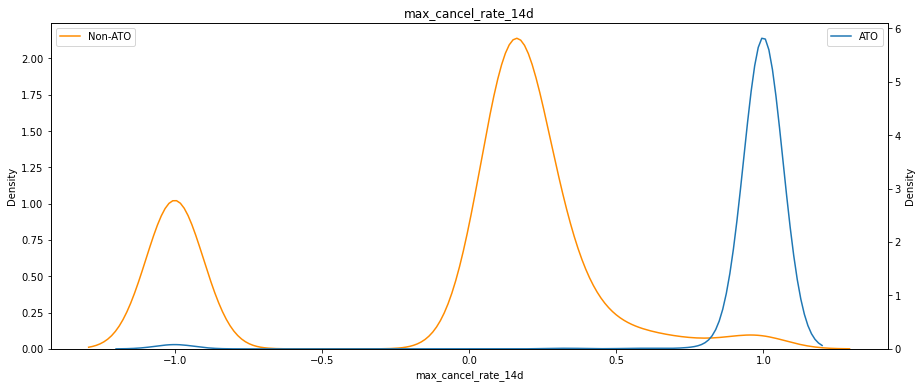

        count      mean       std  min   25%       50%       75%  max
label                                                                
0.0    6000.0 -0.079968  0.555606 -1.0 -0.25  0.143641  0.211817  1.0
1.0     524.0  0.969174  0.232524 -1.0  1.00  1.000000  1.000000  1.0
max_cancel_rate_14d
------------------------------------------------------------------------


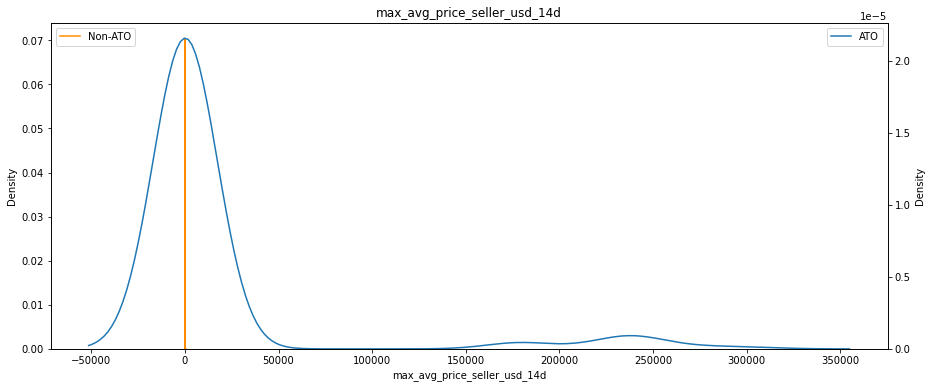

        count          mean           std  min       25%         50%  \
label                                                                  
0.0    6000.0      6.832875     24.723131 -1.0  -0.25000    2.239425   
1.0     524.0  16708.536486  59978.157617 -1.0  91.55695  151.923571   

              75%            max  
label                             
0.0      4.821783     361.394235  
1.0    227.602338  303585.025826  
max_avg_price_seller_usd_14d
------------------------------------------------------------------------


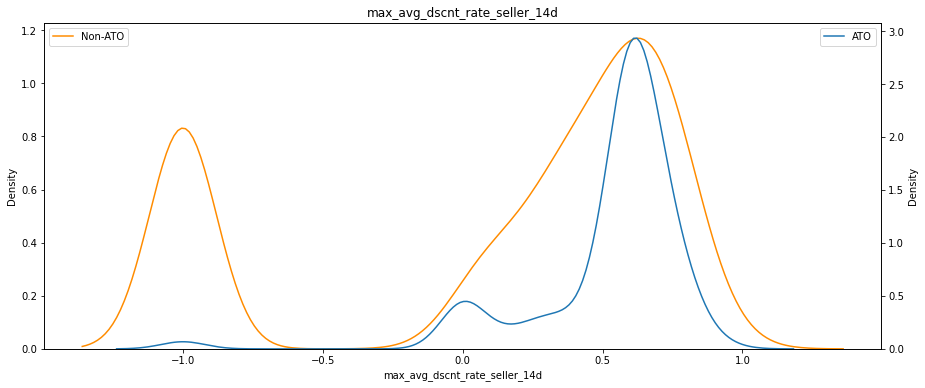

        count      mean       std  min       25%       50%       75%       max
label                                                                         
0.0    6000.0  0.131539  0.683326 -1.0 -0.431818  0.418993  0.646670  1.000000
1.0     524.0  0.528040  0.276492 -1.0  0.523935  0.600951  0.661186  0.945219
max_avg_dscnt_rate_seller_14d
------------------------------------------------------------------------


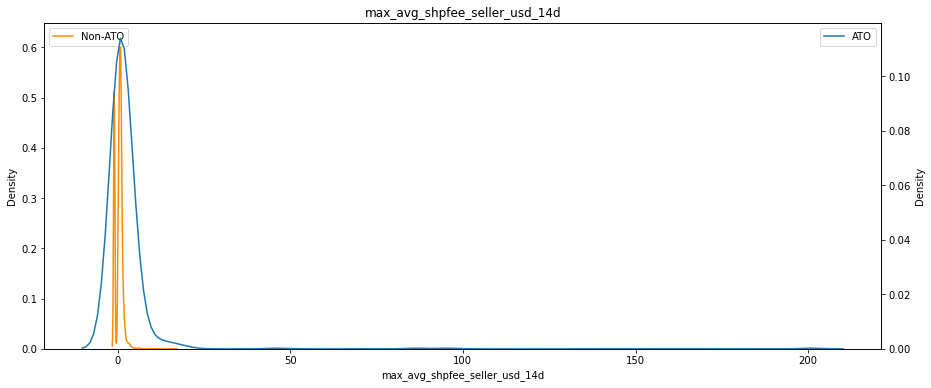

        count      mean        std  min   25%       50%       75%         max
label                                                                        
0.0    6000.0  0.420592   1.105324 -1.0 -0.25  0.582212  0.951009   16.584402
1.0     524.0  2.400641  10.806658 -1.0  0.00  0.989749  1.800544  200.882265
max_avg_shpfee_seller_usd_14d
------------------------------------------------------------------------


In [7]:
for i in range(len(features_to_use)):
    feature_name = features_to_use[i]
    feature_type = features_type[i]
    display_kdeplot(df, feature_name, 'label', feature_type)
    print('------------------------------------------------------------------------')

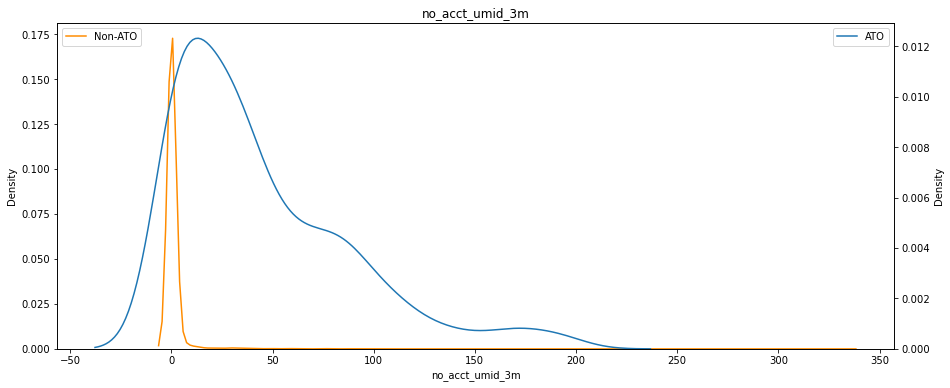

        count       mean        std  min   25%   50%   75%    max
label                                                            
0.0    6000.0   1.396500  12.012008  0.0  0.00   0.0   0.0  332.0
1.0     524.0  44.471374  44.030030  0.0  9.75  31.5  69.0  199.0
no_acct_umid_3m


In [8]:
def normalize(num):
    if num >= 500:
        return 30
    else: 
        return num
df_modify = df
df_modify['no_acct_umid_3m'] = df_modify['no_acct_umid_3m'].apply(normalize)

display_kdeplot(df_modify, 'no_acct_umid_3m', 'label', False)

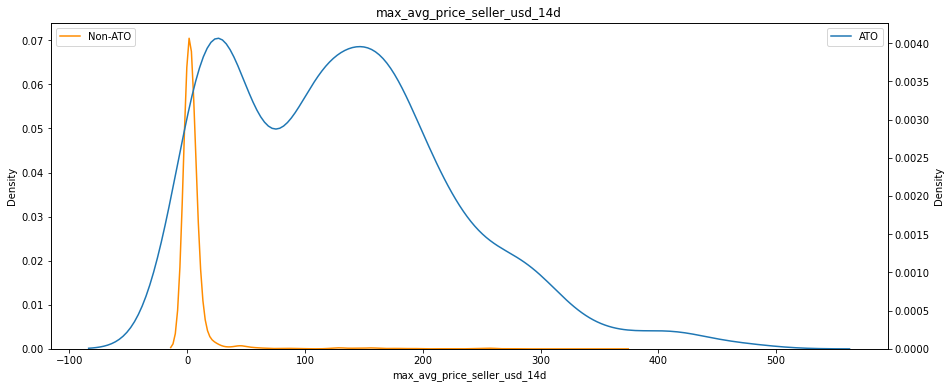

        count        mean        std  min    25%         50%         75%  \
label                                                                      
0.0    6000.0    6.832875  24.723131 -1.0  -0.25    2.239425    4.821783   
1.0     524.0  130.246434  96.448321 -1.0  30.00  124.457089  182.630699   

              max  
label              
0.0    361.394235  
1.0    479.510792  
max_avg_price_seller_usd_14d


In [9]:
def normalize2(num):
    if num >= 5000:
        return 5
    else: 
        return num
df_modify = df
df_modify['max_avg_price_seller_usd_14d'] = df_modify['max_avg_price_seller_usd_14d'].apply(normalize)

display_kdeplot(df_modify, 'max_avg_price_seller_usd_14d', 'label', False)

## 4. Training process (to achieve total bad cases)

### Baseline Parameters

In [10]:
xgb_base_param = {
    'min_child_weight': 1,
    'colsample_bytree' : 0.8,
    'gamma' : 0.5,
    'max_depth' : 5,
    'random_state' : 0,
    'subsample' : 0.8,
    'verbosity' : 0,
    'user_label_encoder' : False
}

rf_base_param = {
    'max_depth' : 16,
    'n_estimators' : 128,
    'min_samples_leaf' : 10,
    'criterion' : 'gini',
    'random_state' : 0
}

### 5-folds training and testing set generation + prediction

In [11]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state = None, shuffle = False)
## skf.get_n_splits(df[features_to_use], df['label'])

df_X, y = df[features_to_use + byr_idx_cols], df['label']

df_X_test_total = pd.DataFrame()
for train_index, test_index in skf.split(df_X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    # have label and buyer_id, intending to save the prediction and make comparision
    df_X_train, df_X_test = df_X.iloc[train_index], df_X.iloc[test_index]
    # exclude label and buyer_id, intending to achieve the training set
    X_train, X_test = df_X_train[features_to_use], df_X_test[features_to_use]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # baseline model
    clf_rf = RandomForestClassifier(**rf_base_param)
    clf_xgb = xgb.XGBClassifier(**xgb_base_param)
    # training
    clf_rf.fit(X_train, y_train)
    clf_xgb.fit(X_train, y_train)
    # prediction
    y_test_preds_prob_rf = clf_rf.predict_proba(X_test)
    y_test_preds_prob_xgb = clf_xgb.predict_proba(X_test)
    df_X_test['rf_predict_prob'], df_X_test['xgb_predict_prob'] = y_test_preds_prob_rf[:,1], y_test_preds_prob_xgb[:,1]
    # achieve all the prediction to find all black cases
    df_X_test_total = df_X_test_total.append(df_X_test, ignore_index = False)
    
# achieve the label based on probability prediction
df_X_test_total['rf_predict_label'], df_X_test_total['xgb_predict_label'] = df_X_test_total['rf_predict_prob'].apply(lambda x: 1 if x > 0.5 else 0), df_X_test_total['xgb_predict_prob'].apply(lambda x: 1 if x > 0.5 else 0)

TRAIN: [1200 1201 1202 ... 6521 6522 6523] TEST: [   0    1    2 ... 6102 6103 6104]
TRAIN: [   0    1    2 ... 6521 6522 6523] TEST: [1200 1201 1202 ... 6207 6208 6209]
TRAIN: [   0    1    2 ... 6521 6522 6523] TEST: [2400 2401 2402 ... 6312 6313 6314]
TRAIN: [   0    1    2 ... 6521 6522 6523] TEST: [3600 3601 3602 ... 6417 6418 6419]
TRAIN: [   0    1    2 ... 6417 6418 6419] TEST: [4800 4801 4802 ... 6521 6522 6523]


### bad cases for the whole dataset

In [12]:
FP_total_xgb = df_X_test_total[(df_X_test_total['label']==0) &(df_X_test_total['xgb_predict_label']==1)]
FN_total_xgb = df_X_test_total[(df_X_test_total['label']==1) &(df_X_test_total['xgb_predict_label']==0)]
FP_total_rf = df_X_test_total[(df_X_test_total['label']==0) &(df_X_test_total['rf_predict_label']==1)]
FN_total_rf = df_X_test_total[(df_X_test_total['label']==1) &(df_X_test_total['rf_predict_label']==0)]

In [13]:
FP_total_rf

,id_new_ip2_3m,id_new_ip3_3m,no_unique_umid_14d,no_unique_ip2_14d,no_login_14d,id_ip_same_seller_14d,id_ip3ua_same_seller_14d,avg_price_per_order_usd_14d,std_price_per_order_usd_14d,avg_dscnt_rate_per_order_14d,...,max_cancel_rate_14d,max_avg_price_seller_usd_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_usd_14d,label,buyer_id,rf_predict_prob,xgb_predict_prob,rf_predict_label,xgb_predict_label
36,0.0,1.0,1.0,2.0,11.0,0.0,0.0,48.069899,85.626781,0.448486,...,1.0,265.250158,0.796520,0.858800,0.0,13078571,0.822683,0.990417,1,1
189,0.0,1.0,1.0,1.0,17.0,0.0,0.0,34.497421,44.532703,0.075186,...,1.0,137.371507,0.388184,1.199931,0.0,27917378,0.558106,0.203735,1,0
480,0.0,0.0,1.0,1.0,1.0,0.0,0.0,76.648546,0.000000,0.000000,...,1.0,90.402943,0.000000,7.387812,0.0,400030736751,0.598830,0.734288,1,1
4787,1.0,1.0,1.0,1.0,3.0,0.0,0.0,13.450425,15.857236,0.290712,...,1.0,50.292847,0.591405,7.015189,0.0,400674549671,0.527070,0.553778,1,1
4793,1.0,1.0,2.0,1.0,2.0,0.0,0.0,10.589065,0.000000,0.500000,...,1.0,28.136866,0.485590,1.103220,0.0,400674678461,0.560326,0.662326,1,1
5478,1.0,1.0,1.0,3.0,10.0,0.0,0.0,9.560371,12.228140,0.247412,...,1.0,14.297128,0.396400,1.140933,0.0,410451054276,0.647579,0.979937,1,1
5775,0.0,0.0,2.0,2.0,8.0,0.0,0.0,18.852153,34.755575,0.248153,...,1.0,53.030603,0.785356,1.477701,0.0,410472729730,0.591631,0.545102,1,1


## 5. Training Process (to achieve the best model w.r.t parameter candidates)

                    Random forest model                      
Fitting 5 folds for each of 27 candidates, totalling 135 fits
====> grid search parameters: 
{
max_depth : [2, 8, 16]
n_estimators : [32, 64, 128]
min_samples_leaf : [5, 20, 30]
bootstrap : [True]
oob_score : [True]
criterion : ['gini']
random_state : [0]
class_weight : ['balanced']
}

====> best estimator: 
{
bootstrap : True
class_weight : balanced
criterion : gini
max_depth : 16
min_samples_leaf : 20
n_estimators : 32
oob_score : True
random_state : 0
}

Train:
Label distribution:
0.0    4799
1.0     420
Name: label, dtype: int64

     F1 score: 0.956120092378753
     AUC: 0.989523114934659
     Accuracy: 0.9927189116689021
     Precision: 0.9282511210762332
     Recall: 0.9857142857142858
	Confusion matrix：
 [[4767   32]
 [   6  414]]

Testing:
Label distribution:
0.0    1201
1.0     104
Name: label, dtype: int64

     F1 score: 0.957345971563981
     AUC: 0.9830790046755908
     Accuracy: 0.993103448275862
     Precisio

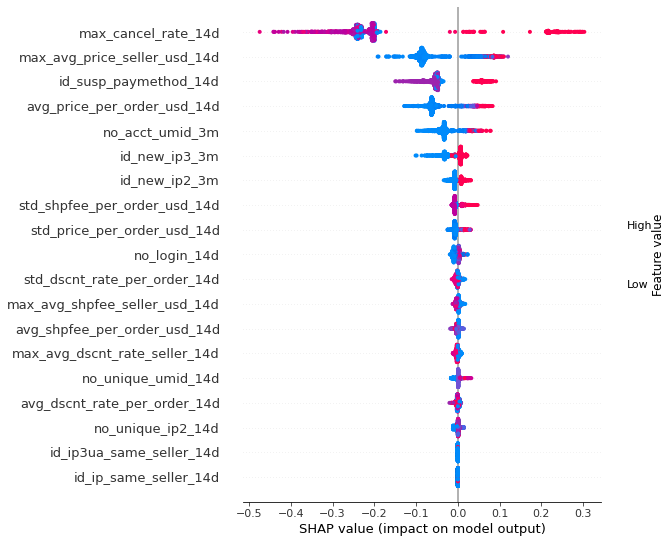

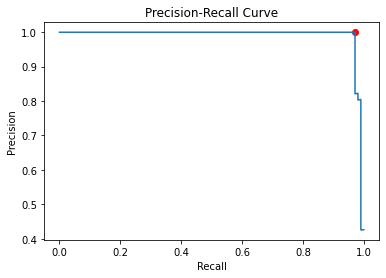

                      Xgboost model                          
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
====> grid search parameters: 
{
min_child_weight : [1, 5, 10]
gamma : [0.5, 1, 1.5, 2, 5]
subsample : [0.6, 0.8, 1.0]
colsample_bytree : [0.6, 0.8, 1.0]
max_depth : [3, 5, 10]
verbosity : [0]
use_label_encoder : [False]
random_state : [0]
}

====> best estimator: 
{
colsample_bytree : 0.8
gamma : 1
max_depth : 5
min_child_weight : 1
random_state : 0
subsample : 0.8
use_label_encoder : False
verbosity : 0
}

Train:
Label distribution:
0.0    4799
1.0     420
Name: label, dtype: int64

     F1 score: 0.9915966386554621
     AUC: 0.9916666666666667
     Accuracy: 0.9986587468863767
     Precision: 1.0
     Recall: 0.9833333333333333
	Confusion matrix：
 [[4799    0]
 [   7  413]]

Testing:
Label distribution:
0.0    1201
1.0     104
Name: label, dtype: int64

     F1 score: 0.9753694581280787
     AUC: 0.9759615384615384
     Accuracy: 0.9961685823754789
     Preci

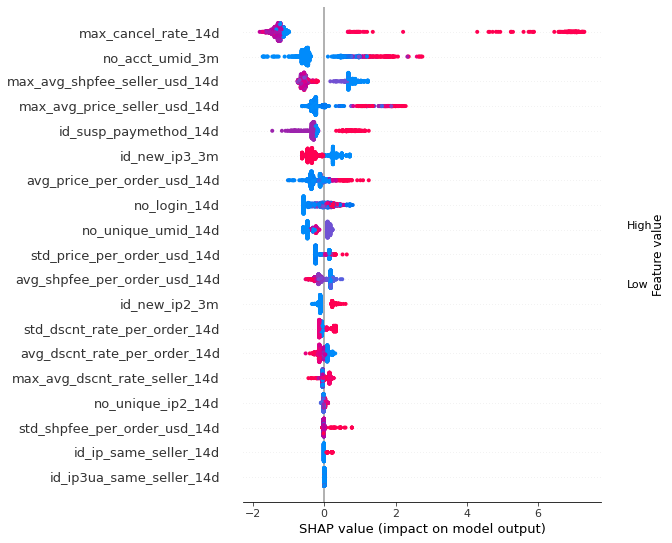

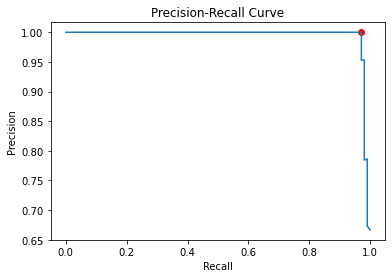

In [14]:
# Run models
res = {}
# generate the dataset to save the model result (df_test)
X_train, y_train, X_test, y_test, df_test = train_test_generation(df, features_to_use, byr_idx_cols,
                                 test_size, random_state)
df_test = df_test.astype(float)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)

for model in model_list:
    res_m = run_model(df, features_to_use, byr_idx_cols, cv,
                     model, model_params[model], threshold_setting, 
                     is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state)
    res[model] = res_m
    # res_m[-2] -> parameters for PR-curve (metric and corresponding threshold)
    # res_m[-1] -> probability prediction for testing sample
    df_test[model+'_pred'] = res_m[-1]

### download the model

In [15]:
clf_rf = res['rf'][0]

In [16]:
pip install scikit2pmml

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
from scikit2pmml import scikit2pmml

is_save_model = True

if is_save_model:
    columns = features_to_use

    params = {
        'pmml_version': '4.2',
        'feature_names': columns,
        'target_values': np.array(['0','1']),
        'target_name': 'label',
        'model_name': 'ATO login model v2'
    }

    scikit2pmml(estimator=clf_rf, file='/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v2/saved model/ato login model v2.pmml', **params)

## 6. Bad cases for RF model

In [21]:
df_test['rf_pred_label'] = df_test['rf_pred'].apply(lambda x: 1 if x > 0.5 else 0)
df_test['xgb_pred_label'] = df_test['xgb_pred'].apply(lambda x: 1 if x > 0.5 else 0)

In [22]:
pd.set_option('display.max_columns', None)
FP = df_test[(df_test['label'] == 1) & (df_test['rf_pred_label'] == 0)]
FP

,label,buyer_id,id_new_ip2_3m,id_new_ip3_3m,no_unique_umid_14d,no_unique_ip2_14d,no_login_14d,id_ip_same_seller_14d,id_ip3ua_same_seller_14d,avg_price_per_order_usd_14d,std_price_per_order_usd_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_usd_14d,std_shpfee_per_order_usd_14d,id_susp_paymethod_14d,no_acct_umid_3m,max_cancel_rate_14d,max_avg_price_seller_usd_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_usd_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
6008,1.0,391244.0,0.0,0.0,1.0,2.0,5.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.078229,0.007863,0,0
6517,1.0,410477370355.0,0.0,1.0,2.0,3.0,5.0,0.0,0.0,121.917054,0.000000,0.300520,0.000000,0.000000,0.000000,1.0,24.0,0.329218,18.918315,0.548326,0.339777,0.263411,0.014877,0,0
6107,1.0,400024710387.0,1.0,1.0,1.0,2.0,11.0,0.0,0.0,155.537828,145.968521,0.404878,0.104765,3.362848,3.362848,1.0,24.0,0.583333,15.120141,0.577240,0.373996,0.241170,0.051109,0,0


## 7. review for best RF model (0621)

### load data and null values imputation

In [23]:
data_file_review = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v2/experiment/exp3/review/review_ato_login_sample_feature_v3_1657615772357.txt'

# load data
df_review = pd.read_csv(data_file_review, delimiter = ',', dtype = str)

# impute null values
# replace null value with -1

df_review = df_review.replace('\\N', -1)
df_review[features_to_impute] = df_review[features_to_impute].astype(float)

### fitting to model

In [24]:
df_review_features = df_review[features_to_use]

df_review_preds_prob_rf = clf_rf.predict_proba(df_review_features)[:,1]
df_review_preds_prob_xgb = clf_xgb.predict_proba(df_review_features)[:,1]

df_review['rf_preds_prob'], df_review['xgb_preds_prob'] = df_review_preds_prob_rf, df_review_preds_prob_xgb

### generating predicted label w.r.t best threshold

In [25]:
df_review['rf_pred_label'] = df_review['rf_preds_prob'].apply(lambda x: 1 if x > 0.85 else 0)
# df_review['xgb_pred_label'] = df_review['xgb_preds_prob'].apply(lambda x: 1 if x > 0.62 else 0)
df_review

,buyer_id,id_new_ip2_3m,id_new_ip3_3m,no_unique_umid_14d,no_unique_ip2_14d,no_login_14d,id_ip_same_seller_14d,id_ip3ua_same_seller_14d,avg_price_per_order_usd_14d,std_price_per_order_usd_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_usd_14d,std_shpfee_per_order_usd_14d,id_susp_paymethod_14d,no_acct_umid_3m,max_cancel_rate_14d,max_avg_price_seller_usd_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_usd_14d,rf_preds_prob,xgb_preds_prob,rf_pred_label
0,1001384,0.0,0.0,1.0,2.0,2.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.029545,0.015497,0
1,10014233,0.0,0.0,1.0,2.0,4.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.059423,0.066614,0
2,10022157,0.0,0.0,1.0,1.0,17.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.006489,0.004214,0
3,10027491,0.0,0.0,1.0,2.0,14.0,0.0,0.0,8.685398,5.823418,0.526874,0.237736,1.100420,0.678873,1.0,0.0,0.406822,13.166274,0.700852,1.092521,0.029330,0.000339,0
4,10045191,0.0,1.0,1.0,1.0,3.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.002245,0.001008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,9978054,0.0,0.0,1.0,2.0,3.0,0.0,0.0,2.299242,0.082429,0.073467,0.006533,0.469664,0.000000,0.0,0.0,0.130132,1.014799,0.089582,0.442052,0.000000,0.000094,0
20708,9980983,0.0,1.0,1.0,2.0,3.0,0.0,0.0,1.311428,0.873408,0.037037,0.052378,0.646638,0.000000,0.0,0.0,0.138674,1.190335,0.031598,0.423269,0.001736,0.000041,0
20709,9997846,0.0,1.0,1.0,1.0,2.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.002456,0.000521,0
20710,9998557,0.0,0.0,10.0,1.0,14.0,0.0,0.0,14.264217,8.257063,0.400544,0.125305,2.355125,1.188236,0.0,0.0,0.193768,8.232581,0.732915,0.963915,0.000000,0.000092,0


### all black prediction

In [26]:
df_review[df_review['rf_pred_label'] == 1]

,buyer_id,id_new_ip2_3m,id_new_ip3_3m,no_unique_umid_14d,no_unique_ip2_14d,no_login_14d,id_ip_same_seller_14d,id_ip3ua_same_seller_14d,avg_price_per_order_usd_14d,std_price_per_order_usd_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_usd_14d,std_shpfee_per_order_usd_14d,id_susp_paymethod_14d,no_acct_umid_3m,max_cancel_rate_14d,max_avg_price_seller_usd_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_usd_14d,rf_preds_prob,xgb_preds_prob,rf_pred_label
468,1590887,1.0,1.0,1.0,4.0,6.0,0.0,0.0,34.174227,27.199634,0.318889,0.255956,0.158823,0.224610,1.0,1.0,1.0,87156.218049,0.424084,0.668133,0.857192,0.999136,1
644,18107980,1.0,1.0,1.0,3.0,11.0,0.0,0.0,14.587482,12.639399,0.261500,0.261500,0.558151,0.088487,0.0,71.0,1.0,36.273165,0.547470,2.091946,0.898233,0.998229,1
5400,400114485127,1.0,1.0,1.0,3.0,21.0,0.0,0.0,76.153584,76.757224,0.308425,0.256245,5.103679,5.162260,0.0,25.0,1.0,103.873638,0.593163,17.620509,0.881081,0.996025,1
7968,400205907540,1.0,1.0,1.0,3.0,16.0,0.0,0.0,14.546654,32.616759,0.289648,0.254298,0.532162,0.294301,0.0,14.0,1.0,181.739421,0.813094,1.990091,0.871505,0.998246,1
7970,400205907540,1.0,1.0,3.0,4.0,18.0,0.0,0.0,14.546654,32.616759,0.289648,0.254298,0.532162,0.294301,0.0,15.0,1.0,181.739421,0.813094,1.990091,0.859136,0.997006,1
8193,400215606377,1.0,1.0,1.0,4.0,24.0,0.0,0.0,11.116508,17.088088,0.196373,0.263375,0.619412,0.571238,0.0,497.0,1.0,48.055444,0.531380,1.997261,0.890648,0.997732,1
10499,400313742582,1.0,1.0,1.0,2.0,12.0,0.0,0.0,29.586392,78.897071,0.234696,0.214328,0.529412,0.208635,1.0,15.0,1.0,186.426076,0.556502,2.042268,0.993224,0.999927,1
10500,400313742582,0.0,1.0,2.0,3.0,13.0,0.0,0.0,29.586392,78.897071,0.234696,0.214328,0.529412,0.208635,1.0,9.0,1.0,186.426076,0.556502,2.042268,0.921513,0.999365,1
10790,400325922966,0.0,1.0,1.0,8.0,11.0,0.0,0.0,42.912967,57.915933,0.344971,0.350800,0.714706,0.503651,0.0,82.0,1.0,120.070931,0.600195,1.652100,0.851547,0.992385,1
17971,410403081127,0.0,1.0,1.0,2.0,5.0,0.0,0.0,70.381486,0.000000,0.599768,0.000000,0.000000,0.000000,1.0,81.0,1.0,103.873638,0.568486,17.620509,0.929233,0.999589,1


### Threshold Selection

#### best threshold according to AOC/AUC

In [27]:
res['rf'][-2][0]

0.6527456137904718

#### all threshold and corresponding Precision/Recall
#####           fix threshold = 0.85 to achieve 100% precision and highest recall

In [179]:
res['rf']

[RandomForestClassifier(class_weight='balanced', max_depth=16,
                        min_samples_leaf=20, n_estimators=32, oob_score=True,
                        random_state=0),
 [0.6191555844480533,
  array([0.41106719, 0.41035857, 0.412     , 0.41532258, 0.41700405,
         0.41869919, 0.42040816, 0.42213115, 0.42386831, 0.42561983,
         0.42738589, 0.42916667, 0.43096234, 0.43277311, 0.43459916,
         0.43644068, 0.43829787, 0.44017094, 0.44396552, 0.44588745,
         0.44978166, 0.45175439, 0.45374449, 0.45575221, 0.45777778,
         0.45982143, 0.46188341, 0.46396396, 0.46606335, 0.46818182,
         0.47685185, 0.47906977, 0.48130841, 0.50738916, 0.50990099,
         0.51243781, 0.515     , 0.51758794, 0.52020202, 0.52284264,
         0.5255102 , 0.52820513, 0.53092784, 0.53367876, 0.53645833,
         0.53926702, 0.54210526, 0.54497354, 0.54787234, 0.55080214,
         0.55376344, 0.55675676, 0.55978261, 0.56284153, 0.56593407,
         0.56906077, 0.57222222, 0.57

## 8. Review for best RF model (0621-0628)

### load data and null values imputation

In [182]:
data_file_review_total = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v2/experiment/exp3/review/review_total_ato_login_sample_feature_v3_1657764141500.txt'

# load data
df_review_total = pd.read_csv(data_file_review, delimiter = ',', dtype = str)

# impute null values
# replace null value with -1

df_review_total = df_review_total.replace('\\N', -1)
df_review_total[features_to_impute] = df_review_total[features_to_impute].astype(float)

### fitting to model

In [184]:
df_review_total_features = df_review_total[features_to_use]

df_review_total_preds_prob_rf = clf_rf.predict_proba(df_review_total_features)[:,1]
df_review_total_preds_prob_xgb = clf_xgb.predict_proba(df_review_total_features)[:,1]

df_review_total['rf_preds_prob'], df_review_total['xgb_preds_prob'] = df_review_total_preds_prob_rf, df_review_total_preds_prob_xgb

### generating predicted label w.r.t best threshold 0.85

In [186]:
df_review_total['rf_pred_label'] = df_review_total['rf_preds_prob'].apply(lambda x: 1 if x > 0.85 else 0)
# df_review['xgb_pred_label'] = df_review['xgb_preds_prob'].apply(lambda x: 1 if x > 0.62 else 0)
df_review_total

,date_predict,buyer_id,id_new_ip2_3m,id_new_ip3_3m,no_unique_umid_14d,no_unique_ip2_14d,no_login_14d,id_ip_same_seller_14d,id_ip3ua_same_seller_14d,avg_price_per_order_usd_14d,std_price_per_order_usd_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_usd_14d,std_shpfee_per_order_usd_14d,id_susp_paymethod_14d,no_acct_umid_3m,max_cancel_rate_14d,max_avg_price_seller_usd_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_usd_14d,rf_preds_prob,xgb_preds_prob,rf_pred_label
0,0621,1001384,0.0,0.0,1.0,2.0,2.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.029296,0.023823,0
1,0621,10014233,0.0,0.0,1.0,2.0,4.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.058040,0.059480,0
2,0621,10022157,0.0,0.0,1.0,1.0,17.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.007109,0.004075,0
3,0621,10027491,0.0,0.0,1.0,2.0,14.0,0.0,0.0,8.685398,5.823418,0.526874,0.237736,1.100420,0.678873,1.0,0.0,0.406822,13.166274,0.700852,1.092521,0.029271,0.000372,0
4,0621,10045191,0.0,1.0,1.0,1.0,3.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.002167,0.000900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141118,0628,9847492,1.0,1.0,1.0,2.0,8.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.004044,0.001696,0
141119,0628,995478,1.0,1.0,1.0,1.0,1.0,0.0,0.0,20.420160,0.000000,0.000000,0.000000,0.986974,0.000000,0.0,0.0,0.117500,9.985068,0.022792,1.584868,0.014589,0.000119,0
141120,0628,9958121,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.000016,0.000118,0
141121,0628,9972814,0.0,1.0,1.0,3.0,7.0,0.0,0.0,4.822561,1.385168,0.039000,0.049000,0.000000,0.000000,1.0,0.0,0.285078,20.866078,0.156395,0.045867,0.012914,0.000460,0


### black prediction

In [231]:
pd.set_option('display.max_rows', 100)
df_review_total[(df_review_total['rf_pred_label']==1)]

,date_predict,buyer_id,id_new_ip2_3m,id_new_ip3_3m,no_unique_umid_14d,no_unique_ip2_14d,no_login_14d,id_ip_same_seller_14d,id_ip3ua_same_seller_14d,avg_price_per_order_usd_14d,std_price_per_order_usd_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_usd_14d,std_shpfee_per_order_usd_14d,id_susp_paymethod_14d,no_acct_umid_3m,max_cancel_rate_14d,max_avg_price_seller_usd_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_usd_14d,rf_preds_prob,xgb_preds_prob,rf_pred_label
468,0621,1590887,1.0,1.0,1.0,4.0,6.0,0.0,0.0,34.174227,27.199634,0.318889,0.255956,0.158823,0.224610,1.0,1.0,1.0,87156.218049,0.424084,0.668133,0.873551,0.999248,1
5400,0621,400114485127,1.0,1.0,1.0,3.0,21.0,0.0,0.0,76.153584,76.757224,0.308425,0.256245,5.103679,5.162260,0.0,25.0,1.0,103.873638,0.593163,17.620509,0.862242,0.997490,1
7968,0621,400205907540,1.0,1.0,1.0,3.0,16.0,0.0,0.0,14.546654,32.616759,0.289648,0.254298,0.532162,0.294301,0.0,14.0,1.0,181.739421,0.813094,1.990091,0.867295,0.998201,1
7970,0621,400205907540,1.0,1.0,3.0,4.0,18.0,0.0,0.0,14.546654,32.616759,0.289648,0.254298,0.532162,0.294301,0.0,15.0,1.0,181.739421,0.813094,1.990091,0.856261,0.996916,1
8193,0621,400215606377,1.0,1.0,1.0,4.0,24.0,0.0,0.0,11.116508,17.088088,0.196373,0.263375,0.619412,0.571238,0.0,497.0,1.0,48.055444,0.531380,1.997261,0.854942,0.997914,1
10499,0621,400313742582,1.0,1.0,1.0,2.0,12.0,0.0,0.0,29.586392,78.897071,0.234696,0.214328,0.529412,0.208635,1.0,15.0,1.0,186.426076,0.556502,2.042268,0.989524,0.999900,1
10500,0621,400313742582,0.0,1.0,2.0,3.0,13.0,0.0,0.0,29.586392,78.897071,0.234696,0.214328,0.529412,0.208635,1.0,9.0,1.0,186.426076,0.556502,2.042268,0.914807,0.999063,1
10790,0621,400325922966,0.0,1.0,1.0,8.0,11.0,0.0,0.0,42.912967,57.915933,0.344971,0.350800,0.714706,0.503651,0.0,82.0,1.0,120.070931,0.600195,1.652100,0.859023,0.992394,1
17971,0621,410403081127,0.0,1.0,1.0,2.0,5.0,0.0,0.0,70.381486,0.000000,0.599768,0.000000,0.000000,0.000000,1.0,81.0,1.0,103.873638,0.568486,17.620509,0.939789,0.999534,1
17972,0621,410403081127,1.0,1.0,2.0,3.0,6.0,0.0,0.0,70.381486,0.000000,0.599768,0.000000,0.000000,0.000000,1.0,9.0,1.0,103.873638,0.568486,17.620509,0.908397,0.999561,1


### split the review set into 10 classes (rank)

In [220]:
needed = ['buyer_id', 'rf_preds_prob']
target_df = df_review_total[needed]
def rank_criterion(prob):
    if 0 <= prob < 0.1:
        return 0
    elif 0.1 <= prob < 0.2:
        return 1
    elif 0.2 <= prob < 0.3:
        return 2
    elif 0.3 <= prob < 0.4:
        return 3
    elif 0.4 <= prob < 0.5:
        return 4
    elif 0.5 <= prob < 0.6:
        return 5
    elif 0.6 <= prob < 0.7:
        return 6
    elif 0.7 <= prob < 0.8:
        return 7
    elif 0.8 <= prob < 0.9:
        return 8
    else:
        return 9
target_df['rank'] = target_df['rf_preds_prob'].apply(rank_criterion)

#### rank distribution

In [230]:
target_df['rank'].value_counts()

0    137561
1      1853
2       876
3       356
4       191
5        86
6        68
8        49
7        44
9        39
Name: rank, dtype: int64

#### rank 9 records (those most dangerous login records)

In [277]:
df_review_total[(df_review_total['rf_preds_prob']<=1)&(df_review_total['rf_preds_prob']>=0.9)]

,date_predict,buyer_id,id_new_ip2_3m,id_new_ip3_3m,no_unique_umid_14d,no_unique_ip2_14d,no_login_14d,id_ip_same_seller_14d,id_ip3ua_same_seller_14d,avg_price_per_order_usd_14d,std_price_per_order_usd_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_usd_14d,std_shpfee_per_order_usd_14d,id_susp_paymethod_14d,no_acct_umid_3m,max_cancel_rate_14d,max_avg_price_seller_usd_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_usd_14d,rf_preds_prob,xgb_preds_prob,rf_pred_label
10499,0621,400313742582,1.0,1.0,1.0,2.0,12.0,0.0,0.0,29.586392,78.897071,0.234696,0.214328,0.529412,0.208635,1.0,15.0,1.0,186.426076,0.556502,2.042268,0.989524,0.999900,1
10500,0621,400313742582,0.0,1.0,2.0,3.0,13.0,0.0,0.0,29.586392,78.897071,0.234696,0.214328,0.529412,0.208635,1.0,9.0,1.0,186.426076,0.556502,2.042268,0.914807,0.999063,1
17971,0621,410403081127,0.0,1.0,1.0,2.0,5.0,0.0,0.0,70.381486,0.000000,0.599768,0.000000,0.000000,0.000000,1.0,81.0,1.0,103.873638,0.568486,17.620509,0.939789,0.999534,1
17972,0621,410403081127,1.0,1.0,2.0,3.0,6.0,0.0,0.0,70.381486,0.000000,0.599768,0.000000,0.000000,0.000000,1.0,9.0,1.0,103.873638,0.568486,17.620509,0.908397,0.999561,1
23370,0622,400025974429,1.0,1.0,1.0,2.0,8.0,0.0,0.0,63.955942,0.000000,0.599744,0.000000,0.000000,0.000000,1.0,83.0,1.0,104.395209,0.570304,16.599031,0.966545,0.999857,1
23371,0622,400025974429,1.0,1.0,2.0,3.0,9.0,1.0,1.0,63.955942,0.000000,0.599744,0.000000,0.000000,0.000000,1.0,88.0,1.0,104.395209,0.570304,16.599031,0.945499,0.999561,1
23372,0622,400025974429,1.0,1.0,3.0,4.0,10.0,0.0,0.0,63.955942,0.000000,0.599744,0.000000,0.000000,0.000000,1.0,26.0,1.0,104.395209,0.570304,16.599031,0.943524,0.999561,1
23989,0622,400041573305,0.0,1.0,3.0,6.0,33.0,0.0,0.0,18.965680,48.415308,0.335498,0.225738,0.330126,0.261882,1.0,6.0,1.0,87172.740350,0.623240,0.966344,0.909405,0.999134,1
34409,0622,400660458471,0.0,1.0,1.0,4.0,12.0,0.0,0.0,48.191578,57.495777,0.358147,0.302644,0.281798,0.230087,1.0,31.0,1.0,206.409558,0.653284,3.225054,0.997442,0.999770,1
41289,0623,400023270667,0.0,1.0,2.0,3.0,3.0,0.0,0.0,92.816435,0.000000,0.600235,0.000000,0.000000,0.000000,1.0,61.0,1.0,92.816435,0.600235,0.000000,0.925849,0.997817,1
